In [44]:
# --- Script to generate plots from spinup run
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- set figure-generating parameters
domain = "field"  # ["field" or "lab"] or just one
prof_list = [
    "prof_aq",
    "prof_aq(ads%cec)",
    "prof_gas",
    "prof_sld(wt%)",
    "sa",
    "sat_sld",
    "rate",
    "bsd",
]
flx_list = ["flx_co2sp", "flx_gas", "flx_aq", "flx_sld", "int_flx_sld", "int_flx_gas"]
flx_plot_excludezeros = True  # True means we don't render lines that contribute no flux the entire timeseries
logtime_color = [
    True,
    False,
]  # [True, False] or just one; whether to make time colorbar a log scale

# --- base names and batch
runs2save = "some"
runname_base = "hifert_cc_311b"
# runname_base = "run1_"
# runname_base = "run1s_gbas"
# runname_base = "run1g2_"
# runname_batch_csv = "basalt_noFert_hist_fixedRate_v4-imix-1.csv"
# runname_batch_csv = "basalt_noFert_hist_fixedRate_v4-imix-seasonal-1.csv"
# runname_batch_csv = "liming_noFert_hist_fixedRate_v4-imix-seasonal-1.csv"
# runname_batch_csv = "liming_noFert_hist_fixedRate_v4-imix-1.csv"
# runname_batch_csv = "liming_noFert_hist_fixedRate_vg2-imix-1.csv"
runname_batch_csv = "meanAnn_liming_shortRun_hiFert_fixedRate_v1.csv"

# runname_base = "liming_noFert_hist_fixedRate_fickmix_site_"  # "meanAnn_liming_noFert_fixedRate_site_"
# runname_batch_csv = "liming_noFert_hist_fixedRate_v2-imix.csv" # "meanAnn_liming_noFert_fixedRate_v0.csv"
# runname_base = "liming_noFert_hist_fixedRate_site_"  # "meanAnn_liming_noFert_fixedRate_site_"
# runname_batch_csv = "liming_noFert_hist_fixedRate_v1.csv" # "meanAnn_liming_noFert_fixedRate_v0.csv"
outdir = "/home/tykukla/SCEPTER/scepter_output"

# --- where to save
save_base = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/figures"

In [45]:
# --- plotting decisions
# ***** PROFILE PLOTS ******
num_cols = 3  # number of columns for multipanel
varmax_threshold = (
    1e-6  # concentrations smaller than this won't get zoomed in on (effectively zero)
)
xax_titlesize = 20
yax_titlesize = 13
xticksize = 14
yticksize = 12
cbar_titlesize = 15
cbar_ticksize = 10

# ***** FLUX PLOTS ******
Fnum_cols = 3  # number of columns for multipanel
Fxax_titlesize = 20
Fyax_titlesize = 13
Fxticksize = 14
Fyticksize = 12
Fcbar_titlesize = 15
Fcbar_ticksize = 10

In [46]:
# --- function to find relevant subdirectories


def find_subdirectories(root_dir, target_string, field_only=True):
    matching_subdirectories = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for dirname in dirnames:
            if target_string in dirname:
                matching_subdirectories.append(os.path.join(dirpath, dirname))
    if field_only:
        # remove elements with "lab" in the directory name
        filtered_directories = [
            directory for directory in matching_subdirectories if "lab" not in directory
        ]
        # print(filtered_directories)
    else:
        filtered_directories = matching_subdirectories
    return filtered_directories

In [47]:
# --- find the directories
alldirs = sorted(find_subdirectories(outdir, runname_base))
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # indices of runs to save
thesedirs = [alldirs[i] for i in indices]
# alldirs
thesedirs

['/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_0p2_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_0p4_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_0p6_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_0p8_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_10p0_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_1p0_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_20p0_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_2p0_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_30p0_cc_field_tau15p0',
 '/home/tykukla/SCEPTER/scepter_output/hifert_cc_311b_3p0_cc_field_tau15p0']

In [48]:
# --- read in run table
csv_loc = "/home/tykukla/aglime-swap-cdr/scepter/batch-inputs"
dfin = pd.read_csv(os.path.join(csv_loc, runname_batch_csv))

# add column for fullname (minus field / lab)
dfin["newrun_id_full"] = (
    dfin["newrun_id"]
    + "_"
    + dfin["dustsp"]
    + "_"
    + domain
    + "_tau"
    + dfin["duration"].astype(float).astype(str).str.replace(".", "p")
)  # (duration has to be turned into float first because otherwise we miss the decimal pt)
# add column for 'site'
dfin["site"] = dfin["spinrun"].str.replace("_spintuneup", "")

# remove runs we don't want to process
dfin["keep"] = False
if runs2save != "all":
    for idx in range(len(dfin)):
        dfin.loc[idx, "keep"] = any(
            (dfin["newrun_id"][idx] in name) for name in thesedirs
        )
    dfin = dfin[dfin["keep"]]  # pull out just keep==True
dfin

,duration,singlerun_seasonality,cec,dustsp,dustsp_2nd,dustrate,dustrate_2nd,dustrad,add_secondary,spinrun,imix,include_psd_full,include_psd_bulk,newrun_id,climatedir,climatefiles,newrun_id_full,site,keep
12,15,False,6.96125,cc,amnt,20.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_0p2,NaN,site_311b,hifert_cc_311b_0p2_cc_field_tau15p0,site_311b_pr74,True
13,15,False,6.96125,cc,amnt,40.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_0p4,NaN,site_311b,hifert_cc_311b_0p4_cc_field_tau15p0,site_311b_pr74,True
14,15,False,6.96125,cc,amnt,60.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_0p6,NaN,site_311b,hifert_cc_311b_0p6_cc_field_tau15p0,site_311b_pr74,True
15,15,False,6.96125,cc,amnt,80.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_0p8,NaN,site_311b,hifert_cc_311b_0p8_cc_field_tau15p0,site_311b_pr74,True
16,15,False,6.96125,cc,amnt,100.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_1p0,NaN,site_311b,hifert_cc_311b_1p0_cc_field_tau15p0,site_311b_pr74,True
17,15,False,6.96125,cc,amnt,200.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_2p0,NaN,site_311b,hifert_cc_311b_2p0_cc_field_tau15p0,site_311b_pr74,True
18,15,False,6.96125,cc,amnt,300.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_3p0,NaN,site_311b,hifert_cc_311b_3p0_cc_field_tau15p0,site_311b_pr74,True
19,15,False,6.96125,cc,amnt,700.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_10p0,NaN,site_311b,hifert_cc_311b_10p0_cc_field_tau15p0,site_311b_pr74,True
20,15,False,6.96125,cc,amnt,1200.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_20p0,NaN,site_311b,hifert_cc_311b_20p0_cc_field_tau15p0,site_311b_pr74,True
21,15,False,6.96125,cc,amnt,2000.0,30.0,150,False,site_311b_pr7_spintuneup4,1,False,False,hifert_cc_311b_30p0,NaN,site_311b,hifert_cc_311b_30p0_cc_field_tau15p0,site_311b_pr74,True


In [49]:
# --- FUNCTION to preprocess .txt files for consistent delimiters
def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [50]:
# --- function to read in profile data


def read_prof_dat(resdir, runname_in, domain_in, prof_list):
    # where results are stored
    dirname = runname_in  # + "_" + domain_in
    results_path = os.path.join(resdir, dirname)
    prof_path = os.path.join(results_path, "prof")

    # create an output list
    dfout = []

    # define file name pattern
    fn_pref = prof_list
    fn_ext = ".txt"

    # loop through variables
    # df = pd.DataFrame()  # initialize empty df to store dat
    for var in fn_pref:
        # read out status
        print("reading in " + var + "...")
        # set pattern
        fn_pattern = f"{var}-*{fn_ext}"
        # get list of filenames
        file_paths = glob.glob(f"{prof_path}/{fn_pattern}")

        # read in data and concatenate
        df = pd.DataFrame()
        for file_path in file_paths:
            # check for special case
            if (
                ("restart" in file_path)
                or ("save" in file_path)
                or ("prof_aq-DIC-" in file_path)
            ):
                continue
            dfi = preprocess_txt(file_path)
            # apply pd.to_numeric to all columns using the "map" method
            dfi = dfi.map(pd.to_numeric)
            # add var
            dfi["var"] = var
            # combine
            df = pd.concat([df, dfi], ignore_index=True)
        # sort and add the new df
        df = df.sort_values(by=["var", "time", "z"])
        dfout.append(df)

    return dfout

In [51]:
# --- function to read in flux data
def read_flx_dat(resdir, runname_in, domain_in, flx_list):
    # where results are stored
    dirname = runname_in  # + "_" + domain_in
    results_path = os.path.join(resdir, dirname)
    flx_path = os.path.join(results_path, "flx")

    # define file name pattern
    fn_pref = flx_list
    fn_varInclude = []
    varCheck = True if len(fn_varInclude) > 0 else False
    fn_ext = ".txt"

    df = pd.DataFrame()  # initialize empty df to store dat

    for fset in fn_pref:
        # read out status
        print("reading in " + fset + "...")
        # set pattern
        fn_pattern = f"{fset}-*{fn_ext}"
        # get list of filenames
        file_paths = glob.glob(f"{flx_path}/{fn_pattern}")

        # read in data and concatenate
        for file_path in file_paths:
            # get the variable
            varpattern = re.escape(fset) + r"-(.*?).txt"
            varmatch = re.search(varpattern, file_path)
            var = varmatch.group(1)
            # skip this step if it's not in the include arr
            if varCheck:
                if var not in fn_varInclude:
                    continue
            # read in
            dfi = preprocess_txt(file_path)
            # apply pd.to_numeric to all columns using the "map" method
            dfi = dfi.map(pd.to_numeric)
            # add set, var, spinrun, ctrl
            dfi["set"] = fset
            dfi["var"] = var

            # combine
            df = pd.concat([df, dfi], ignore_index=True)

    # drop all time slices dangerously close to zero (these produce astronomical (like 10^10 or higher) residuals)
    # df = df.loc[df['time'] > 1e-3]

    # sort by time and depth
    df = df.sort_values(by=["set", "var", "time"])
    return df

In [52]:
def plot_profile(
    df,
    tdf,
    save_base,
    domain_in,
    logtime_color,
    num_cols=3,
    xax_titlesize=20,
    yax_titlesize=13,
    xticksize=14,
    yticksize=12,
    cbar_titlesize=15,
    cbar_ticksize=10,
    save_dpi=250,
    save_transparent=False,
    plot_prefix="PROF_",
):

    # --- turn off interactive mode
    plt.ioff()

    # --- set the output directory
    # save_prof_dir = os.path.join(save_base, tdf['site'], domain_in)
    save_prof_dir = os.path.join(save_base, tdf["newrun_id"], domain_in)
    # create it if it doesn't exist
    if not os.path.exists(save_prof_dir):
        os.makedirs(save_prof_dir)

    # --- get list of variables to loop through
    # thesevars = df['var'].unique()

    # LOOP ONE --- VARS
    for tvar in range(len(df)):
        # extract just the variable we want
        dfx = df[tvar]  # df[df['var'] == thisvar]
        thisvar = dfx["var"][0]
        # remove columns with all nan
        dfx1 = dfx.dropna(axis=1, how="all")
        # remove columns whose names are numbers
        number_pattern = re.compile(
            r"^[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?$"
        )  # required to detect columns that are numbers
        for col in dfx1.columns:
            if number_pattern.match(col):
                dfx1.drop(columns=col, inplace=True)
        # set the plot df
        dfp = dfx1

        # LOOP 2 --- WHETHER COLOR BAR IS A LOG SCALE
        for log_col in logtime_color:
            # Get the list of variables
            variables = [col for col in dfp.columns if col not in ["z", "time", "var"]]

            # group by time
            grouped = dfp.groupby("time")

            # Calculate number of rows and columns for subplots
            num_rows = -(-len(variables) // num_cols)  # Round up division

            # Create a colormap
            cmap = plt.get_cmap("magma")  # Get the colormap
            cmap = cmap.reversed()  # flip colormap
            # -- no log normalization
            if not log_col:
                norm = plt.Normalize(
                    dfx["time"].min(), dfx["time"].max()
                )  # Normalize time values for colormap
            # -- log normalization WIP
            else:
                log_time = np.log(dfx["time"])
                norm = plt.Normalize(
                    log_time.min(), log_time.max()
                )  # Normalize time values for colormap

            # Create a colorbar based on the Viridis colormap
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

            # Create subplots
            fig, axes = plt.subplots(
                num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows)
            )

            # Plot each variable versus depth
            for i, var in enumerate(variables):
                row = i // num_cols
                col = i % num_cols
                ax = axes[row, col] if num_rows > 1 else axes[col]
                # get max (to determine how to handle y-axis)
                varmax = np.nanmax(dfp[var])

                # Create a plot for each time step
                for time, group in grouped:
                    color = cmap(norm(time))  # Map time to color using Viridis colormap
                    ax.plot(
                        group[var], group["z"], color=color, label=None, linewidth=3
                    )
                ax.set_ylabel("Depth", size=yax_titlesize)
                ax.set_xlabel(var, size=xax_titlesize)
                ax.tick_params(
                    axis="x", which="major", labelsize=xticksize
                )  # Adjust the size as needed
                ax.tick_params(
                    axis="y", which="major", labelsize=yticksize
                )  # Adjust the size as needed
                # set limits if needed
                if varmax < varmax_threshold:
                    ax.set_xlim(0, varmax_threshold)
                ax.invert_yaxis()

            # Remove empty subplots
            for i in range(len(variables), num_rows * num_cols):
                row = i // num_cols
                col = i % num_cols
                fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

            # add colorbar
            sm.set_array([])  # Set an empty array for the colorbar data
            if log_col:
                colorlabel = "logTime (yr)"
                cbar = plt.colorbar(sm, label=colorlabel, ax=plt.gca())
            else:
                colorlabel = "Time (yr)"
                cbar = plt.colorbar(sm, label=colorlabel, ax=plt.gca())
            cbar.set_label(colorlabel, fontsize=cbar_titlesize)
            cbar.ax.tick_params(labelsize=cbar_ticksize)

            plt.tight_layout()
            # plt.show()

            # --- save the result
            if log_col:
                fname = plot_prefix + thisvar + "_logColor.png"
            else:
                fname = plot_prefix + thisvar + ".png"
            plt.savefig(
                os.path.join(save_prof_dir, fname),
                dpi=250,
                bbox_inches="tight",
                transparent=save_transparent,
            )
            # --- close to release memory
            plt.close()

    # --- turn interactive mode back on
    plt.ion()

In [53]:
def plot_flx(
    df,
    tdf,
    save_base,
    domain_in,
    mycmap="magma",
    color_start=0.1,
    color_end=0.9,
    Fnum_cols=3,
    Fxax_titlesize=20,
    Fyax_titlesize=13,
    Fxticksize=14,
    Fyticksize=12,
    save_dpi=250,
    save_transparent=False,
    plot_prefix="FLUX_",
):
    # --- turn interactive mode off
    plt.ioff()
    # --- set the output directory
    # save_prof_dir = os.path.join(save_base, tdf['site'], domain_in)
    save_prof_dir = os.path.join(save_base, tdf["newrun_id"], domain_in)
    # create it if it doesn't exist
    if not os.path.exists(save_prof_dir):
        os.makedirs(save_prof_dir)

    # --- get list of variables to loop through
    thesesets = df["set"].unique()

    # --- LOOP 1: THIS SET
    for thisset in thesesets:
        dfset = df[df["set"] == thisset]

        # --- get a color dictionary
        if flx_plot_excludezeros:  # remove columns with all zeros
            dftmp = dfset.loc[:, (dfset != 0).any(axis=0)]
        allflux_components = [
            col for col in dftmp.columns if col not in ["set", "time", "var"]
        ]
        cmap = plt.get_cmap(mycmap)
        num_colors = len(allflux_components)
        colors = cmap(np.linspace(color_start, color_end, num_colors))
        color_dict = dict(zip(allflux_components, colors))

        # --- get vars
        thesevars = dfset["var"].unique()

        # --- Calculate number of rows and columns for subplots
        num_rows = -(-len(thesevars) // Fnum_cols)  # Round up division
        # count which panel we're on
        cnt = 0

        # --- Create subplots
        fig, axes = plt.subplots(
            num_rows, Fnum_cols, figsize=(5 * Fnum_cols, 4 * num_rows)
        )

        # --- LOOP 2: THESEVARS
        for thisvar in thesevars:
            # extract just the variable we want
            dfx = dfset[dfset["var"] == thisvar]
            # check if this is an integrated var
            if "int" in thisset:
                int_on = True
            else:
                int_on = False
            # remove columns with all nan
            dfx1 = dfx.dropna(axis=1, how="all")
            # remove columns with all zeros
            if flx_plot_excludezeros:
                dfx2 = dfx1.loc[:, (dfx1 != 0).any(axis=0)]
            else:
                dfx2 = dfx1
            # remove columns whose names are numbers
            number_pattern = re.compile(
                r"^[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?$"
            )  # required to detect columns that are numbers
            for col in dfx2.columns:
                if number_pattern.match(col):
                    dfx2.drop(columns=col, inplace=True)
            # set the plot df
            dfp = dfx2

            # correct multiple instances of cc
            if "cc" in dfp.columns:
                if len(dfp["cc"].shape) > 1:
                    if dfp["cc"].shape[1] > 1:
                        dfp = dfp.drop(columns="cc", axis=1)
            # correct multiple instances of gbas
            if "gbas" in dfp.columns:
                if len(dfp["gbas"].shape) > 1:
                    if dfp["gbas"].shape[1] > 1:
                        dfp = dfp.drop(columns="gbas", axis=1)

            # Get the list of variables
            variables = [
                col for col in dfp.columns if col not in ["set", "time", "var"]
            ]

            # Plot each variable versus time
            row = cnt // Fnum_cols
            col = cnt % Fnum_cols

            for i, var in enumerate(variables):
                ax = axes[row, col] if num_rows > 1 else axes[col]
                if i % 2 == 0:
                    linestylex = "--"  # if even,
                else:
                    linestylex = "solid"
                if int_on:
                    ax.plot(
                        dfp["time"],
                        dfp[var] * dfp["time"],
                        color=color_dict[var],
                        label=var,
                        linewidth=3,
                        linestyle=linestylex,
                    )
                else:
                    ax.plot(
                        dfp["time"],
                        dfp[var],
                        color=color_dict[var],
                        label=var,
                        linewidth=3,
                        linestyle=linestylex,
                    )
            ax.set_title(thisvar)
            ax.set_ylabel("flux", size=Fyax_titlesize)
            ax.set_xlabel("Time (yr)", size=Fxax_titlesize)
            ax.tick_params(
                axis="x", which="major", labelsize=Fxticksize
            )  # Adjust the size as needed
            ax.tick_params(
                axis="y", which="major", labelsize=Fyticksize
            )  # Adjust the size as needed
            ax.legend()

            # update cnt
            cnt += 1

        # Remove empty subplots
        for i in range(len(variables), num_rows * Fnum_cols):
            row = i // Fnum_cols
            col = i % Fnum_cols
            fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

        # add colorbar
        plt.tight_layout()
        # plt.show()

        # --- save the result
        fname = plot_prefix + thisset + ".png"
        plt.savefig(
            os.path.join(save_prof_dir, fname),
            dpi=250,
            bbox_inches="tight",
            transparent=save_transparent,
        )
        # --- close to release memory
        plt.close()

    # --- turn interactive mode back on
    plt.ion()

In [54]:
# --- run the loop and generate figures
resdir = "/home/tykukla/SCEPTER/scepter_output"  # location of output directories

# select which runs to use
if runs2save == "all":
    dfin = dfin
# ELSE... select all the spinnames from a list

# LOOP -------------------------------------------------------
# --- first across all runs
for trun in range(len(dfin)):
    runname_in = dfin["newrun_id_full"].iloc[trun]
    tdf = dfin.iloc[trun]

    # ***** PROFILE DATA ***** #
    # read in
    df = read_prof_dat(resdir, runname_in, domain, prof_list)
    # plot + save ----------------------------------------------------
    plot_profile(df, tdf, save_base, domain, logtime_color)
    # ----------------------------------------------------------------

    # ***** FLUX DATA ***** #
    # read in
    df_flx = read_flx_dat(resdir, runname_in, domain, flx_list)
    # plot + save ----------------------------------------------------
    plot_flx(df_flx, tdf, save_base, domain)
    # ----------------------------------------------------------------

reading in prof_aq...
reading in prof_aq(ads%cec)...
reading in prof_gas...
reading in prof_sld(wt%)...
reading in sa...
reading in sat_sld...
reading in rate...
reading in bsd...
reading in flx_co2sp...
reading in flx_gas...
reading in flx_aq...
reading in flx_sld...
reading in int_flx_sld...
reading in int_flx_gas...
reading in prof_aq...


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# -----
# -----
#
#
# EVERYTHING BELOW THIS IS SCRATCH...
#
#
# -----
# -----

In [ ]:
resdir = "/home/tykukla/SCEPTER/scepter_output"  # location of output directories
trun = 0
runname_in = dfin["newrun_id_full"].iloc[trun]
tdf = dfin.iloc[trun]

# ***** PROFILE DATA ***** #
# read in
df = read_prof_dat(resdir, runname_in, domain, prof_list)
df

In [16]:
# where results are stored
df = df_flx
runname_in = dfin["newrun_id_full"][0]
dirname = runname_in  # + "_" + domain_in
results_path = os.path.join(resdir, dirname)
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(
    results_path, "prof"
)

# create an output list
dfout = []

# define file name pattern
fn_pref = prof_list
fn_ext = ".txt"

# loop through variables
# df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # read out status
    print("reading in " + var + "...")
    # set pattern
    fn_pattern = f"{var}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")

    # read in data and concatenate
    df = pd.DataFrame()
    for file_path in file_paths:
        # check for special case
        if (
            ("restart" in file_path)
            or ("save" in file_path)
            or ("prof_aq-DIC-" in file_path)
        ):
            continue
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)
    # sort and add the new df
    df = df.sort_values(by=["var", "time", "z"])
    dfout.append(df)


# sort by time and depth
# df = df.sort_values(by=["var", "time", "z"])

reading in prof_aq...
reading in prof_aq(ads%cec)...
reading in prof_gas...
reading in prof_sld(wt%)...
reading in sa...
reading in rate...


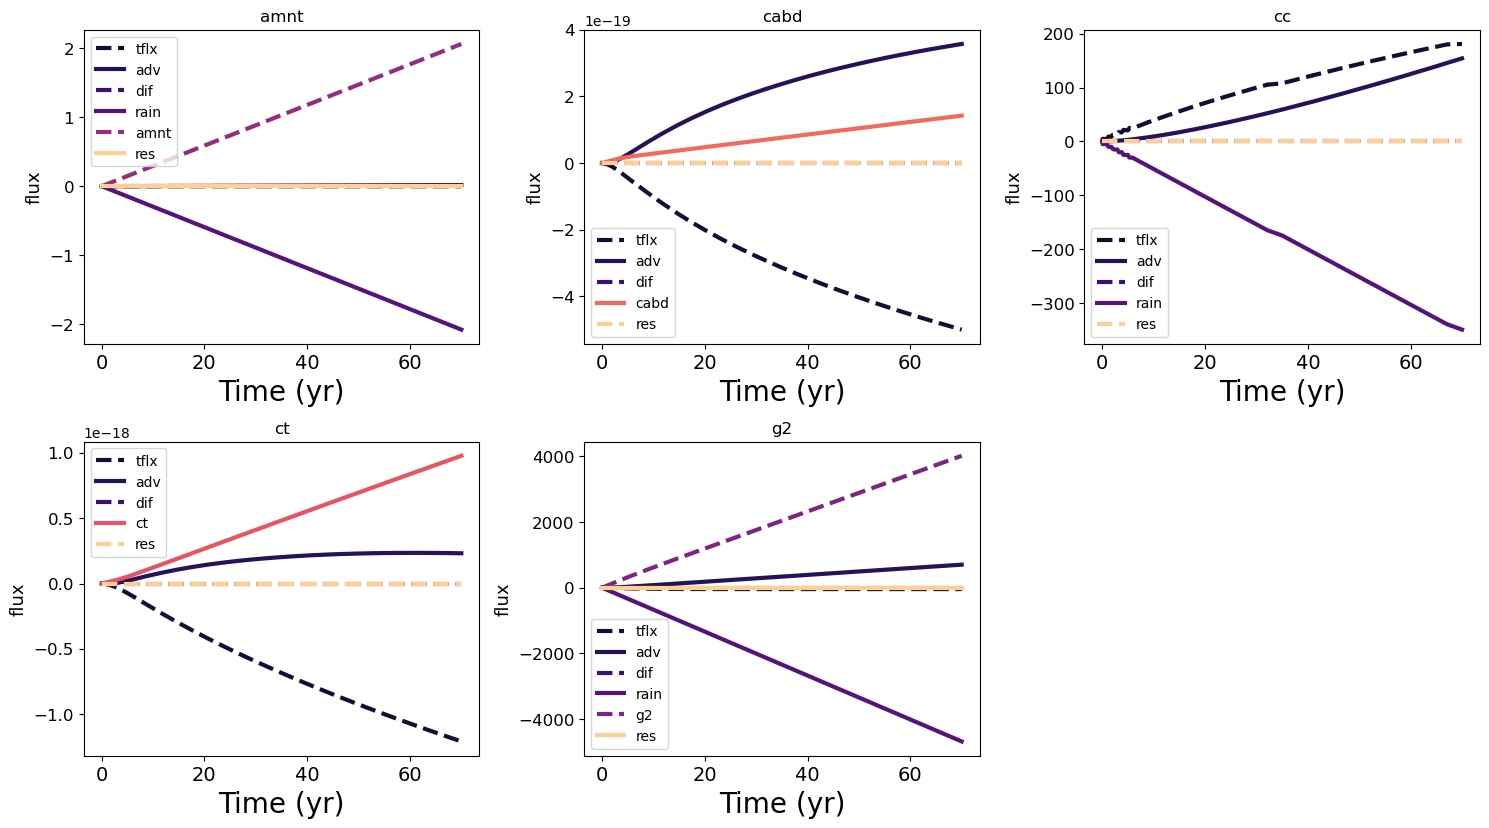

In [70]:
# --- set the output directory
df = df_flx
domain_in = "field"
mycmap = "magma"
color_start = 0.1
color_end = 0.9
Fnum_cols = 3
Fxax_titlesize = 20
Fyax_titlesize = 13
Fxticksize = 14
Fyticksize = 12
save_dpi = 250
save_transparent = False
plot_prefix = "FLUX_"


# save_prof_dir = os.path.join(save_base, tdf['site'], domain_in)
save_prof_dir = os.path.join(save_base, tdf["newrun_id"], domain_in)
# create it if it doesn't exist
if not os.path.exists(save_prof_dir):
    os.makedirs(save_prof_dir)

# --- get list of variables to loop through
thesesets = df["set"].unique()


# --- LOOP 1: THIS SET
thisset = "int_flx_sld"
dfset = df[df["set"] == thisset]

# --- get a color dictionary
if flx_plot_excludezeros:  # remove columns with all zeros
    dftmp = dfset.loc[:, (dfset != 0).any(axis=0)]
allflux_components = [col for col in dftmp.columns if col not in ["set", "time", "var"]]
cmap = plt.get_cmap(mycmap)
num_colors = len(allflux_components)
colors = cmap(np.linspace(color_start, color_end, num_colors))
color_dict = dict(zip(allflux_components, colors))

# --- get vars
thesevars = dfset["var"].unique()

# --- Calculate number of rows and columns for subplots
num_rows = -(-len(thesevars) // Fnum_cols)  # Round up division
# count which panel we're on
cnt = 0

# --- Create subplots
fig, axes = plt.subplots(num_rows, Fnum_cols, figsize=(5 * Fnum_cols, 4 * num_rows))


# --- LOOP 2: THESEVARS
for thisvar in thesevars:
    # extract just the variable we want
    dfx = dfset[dfset["var"] == thisvar]
    # check if this is an integrated var
    if "int" in thisset:
        int_on = True
    else:
        int_on = False
    # remove columns with all nan
    dfx1 = dfx.dropna(axis=1, how="all")
    # remove columns with all zeros
    if flx_plot_excludezeros:
        dfx2 = dfx1.loc[:, (dfx1 != 0).any(axis=0)]
    else:
        dfx2 = dfx1
    # remove columns whose names are numbers
    number_pattern = re.compile(
        r"^[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?$"
    )  # required to detect columns that are numbers
    for col in dfx2.columns:
        if number_pattern.match(col):
            dfx2.drop(columns=col, inplace=True)
    # set the plot df
    dfp = dfx2

    # correct multiple instances
    if "cc" in dfp.columns:
        if len(dfp["cc"].shape) > 1:
            if dfp["cc"].shape[1] > 1:
                dfp = dfp.drop(columns=thisvar, axis=1)
    # Get the list of variables
    variables = [col for col in dfp.columns if col not in ["set", "time", "var"]]

    # Plot each variable versus time
    row = cnt // Fnum_cols
    col = cnt % Fnum_cols

    for i, var in enumerate(variables):
        ax = axes[row, col] if num_rows > 1 else axes[col]
        if i % 2 == 0:
            linestylex = "--"  # if even,
        else:
            linestylex = "solid"
        if int_on:
            ax.plot(
                dfp["time"],
                dfp[var] * dfp["time"],
                color=color_dict[var],
                label=var,
                linewidth=3,
                linestyle=linestylex,
            )
        else:
            ax.plot(
                dfp["time"],
                dfp[var],
                color=color_dict[var],
                label=var,
                linewidth=3,
                linestyle=linestylex,
            )
    ax.set_title(thisvar)
    ax.set_ylabel("flux", size=Fyax_titlesize)
    ax.set_xlabel("Time (yr)", size=Fxax_titlesize)
    ax.tick_params(
        axis="x", which="major", labelsize=Fxticksize
    )  # Adjust the size as needed
    ax.tick_params(
        axis="y", which="major", labelsize=Fyticksize
    )  # Adjust the size as needed
    ax.legend()

    # update cnt
    cnt += 1

# Remove empty subplots
for i in range(len(variables), num_rows * Fnum_cols):
    row = i // Fnum_cols
    col = i % Fnum_cols
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

# add colorbar
plt.tight_layout()
# plt.show()

In [68]:
# if dfp[thisvar].shape[1] > 1:
dfp

,time,tflx,adv,dif,rain,res,set,var
2176,0.000584,24.540015,0.000604,-1.490049e-19,-99.911079,1.701031e-09,int_flx_sld,cc
2177,0.000584,24.540015,0.000604,-3.706731e-20,-99.911079,1.815743e-09,int_flx_sld,cc
2178,0.001751,66.264927,0.004191,-2.361369e-18,-99.911079,5.657206e-10,int_flx_sld,cc
2179,0.001751,66.264927,0.004191,-2.324014e-18,-99.911079,6.040000e-10,int_flx_sld,cc
2180,0.005834,89.666822,0.020177,4.147699e-18,-99.911079,1.684754e-10,int_flx_sld,cc
...,...,...,...,...,...,...,...,...
2299,64.166668,2.718239,2.139990,-7.892997e-17,-5.060431,-1.693844e-06,int_flx_sld,cc
2300,67.083334,2.688509,2.173651,-5.523081e-17,-5.063816,-1.675358e-06,int_flx_sld,cc
2301,67.083334,2.688509,2.173651,-5.330867e-17,-5.063816,-1.675358e-06,int_flx_sld,cc
2302,70.000000,2.588200,2.206204,-5.613186e-17,-4.995554,-1.690778e-06,int_flx_sld,cc


In [56]:
# df_flx[df_flx['set'] == thisset]
dfxx = dfp
# dfxx.drop_duplicates(subset=['cc'], keep='first')
second_occurrence_index = dfxx.columns.tolist().index(
    "cc", dfxx.columns.tolist().index("cc") + 1
)
dfxx.drop(dfxx.columns[second_occurrence_index], axis=1)
# dfxx.drop(columns="cc", axis=1)

,time,tflx,adv,dif,rain,res,set,var
2176,0.000584,24.540015,0.000604,-1.490049e-19,-99.911079,1.701031e-09,int_flx_sld,cc
2177,0.000584,24.540015,0.000604,-3.706731e-20,-99.911079,1.815743e-09,int_flx_sld,cc
2178,0.001751,66.264927,0.004191,-2.361369e-18,-99.911079,5.657206e-10,int_flx_sld,cc
2179,0.001751,66.264927,0.004191,-2.324014e-18,-99.911079,6.040000e-10,int_flx_sld,cc
2180,0.005834,89.666822,0.020177,4.147699e-18,-99.911079,1.684754e-10,int_flx_sld,cc
...,...,...,...,...,...,...,...,...
2299,64.166668,2.718239,2.139990,-7.892997e-17,-5.060431,-1.693844e-06,int_flx_sld,cc
2300,67.083334,2.688509,2.173651,-5.523081e-17,-5.063816,-1.675358e-06,int_flx_sld,cc
2301,67.083334,2.688509,2.173651,-5.330867e-17,-5.063816,-1.675358e-06,int_flx_sld,cc
2302,70.000000,2.588200,2.206204,-5.613186e-17,-4.995554,-1.690778e-06,int_flx_sld,cc


In [37]:
df_flx["set"].unique()

array(['flx_aq', 'flx_co2sp', 'flx_gas', 'flx_sld', 'int_flx_gas',
       'int_flx_sld'], dtype=object)

In [15]:
df[0]

,z,ca,k,mg,na,no3,ph,time,var
90,0.008333,0.000013,2.537755e-21,6.356093e-22,2.579896e-21,0.000018,6.089731,0.000584,prof_aq
91,0.025000,0.000045,4.715242e-21,2.200531e-21,4.707323e-21,0.000032,5.819928,0.000584,prof_aq
92,0.041667,0.000067,5.762444e-21,3.285186e-21,5.765149e-21,0.000045,5.732937,0.000584,prof_aq
93,0.058333,0.000085,6.512282e-21,4.195369e-21,6.519190e-21,0.000059,5.679841,0.000584,prof_aq
94,0.075000,0.000101,7.106125e-21,4.995141e-21,7.115809e-21,0.000072,5.641958,0.000584,prof_aq
...,...,...,...,...,...,...,...,...,...
415,0.425000,0.000120,2.734882e-19,6.795201e-19,8.364464e-16,0.000200,5.604966,70.000000,prof_aq
416,0.441667,0.000120,2.534118e-19,6.366271e-19,8.840009e-16,0.000200,5.604968,70.000000,prof_aq
417,0.458333,0.000120,2.306039e-19,5.913274e-19,9.197257e-16,0.000200,5.604970,70.000000,prof_aq
418,0.475000,0.000120,2.075401e-19,5.568603e-19,9.439374e-16,0.000200,5.604971,70.000000,prof_aq
